This notebook contains the final graphs and visualizations we want to put on our Data Story website.

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import csv
import pickle
import networkx as nx
import statsmodels.formula.api as smf
from scipy.stats import sem
%matplotlib inline

In [2]:
#File and folder names
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'
ALL_DATASETS = DATA_FOLDER + 'merge_all.pkl'

In [3]:
#Read pickles
characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)
df_all = pd.read_pickle(ALL_DATASETS)

In [26]:
#For matching study
G = nx.read_gpickle("Data/matching_1.gpickle")

In [4]:
def col_to_year_fmt(df,col_name):
    '''change format of column col_name of dataframe df to datetime year format'''
    df[col_name] = pd.to_datetime(df[col_name],format='%Y').dt.year

col_to_year_fmt(movies,'Movie_release_date')
col_to_year_fmt(df_all,'Movie_release_date')
col_to_year_fmt(characters,'Movie_release_date')
col_to_year_fmt(characters,'Actor_date_of_birth')

# Drop useless columns
movies.drop(['Movie_runtime'],axis=1, inplace=True)
df_all.drop(['Movie_runtime'],axis=1, inplace=True)

# Drop NaN
characters = characters.dropna()
movies = movies.dropna()

In [5]:
#Access the log of revenue with log_revenue, log of budget with log_budget
def add_log(df,col,new_col):
    '''add the column new_col to the dataframe df, containing the log10 of column col'''
    df[new_col] = df[col].apply(np.log10)

add_log(movies,'Movie_box_office_revenue','log_revenue')
add_log(df_all,'Movie_box_office_revenue','log_revenue')
add_log(df_all,'budget','log_budget')

In [6]:
characters.Actor_gender = (characters.Actor_gender=='F').apply(int)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,1,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,0,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,1,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


### Visualizations
#### Evolution of fraction of female actors over time

In [72]:
SAVE_FIG = False #False to not save again figures in the Images folder, True if we want to update the figure

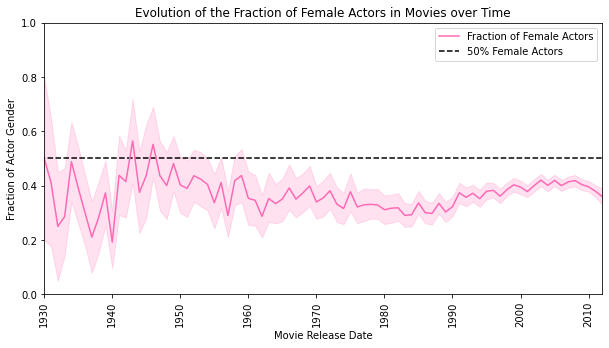

In [70]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = characters, x=characters.Movie_release_date[characters.Movie_release_date > 1929][characters.Movie_release_date < 2013], y='Actor_gender', ax=ax, label='Fraction of Female Actors', color='hotpink')
plt.hlines(0.5,1920,2020,color='black',linestyle='--',label='50% Female Actors')
plt.xlim([1930, 2012]) #remove data from 1915-1930 because there are not enough movies
plt.xlabel('Movie Release Date')
plt.ylim([0, 1])
plt.ylabel('Fraction of Actor Gender')
#plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the Fraction of Female Actors in Movies over Time')
plt.legend()

if SAVE_FIG:
    plt.savefig('Images/Female_actors_over_time.png')

#### Age and Gender gap

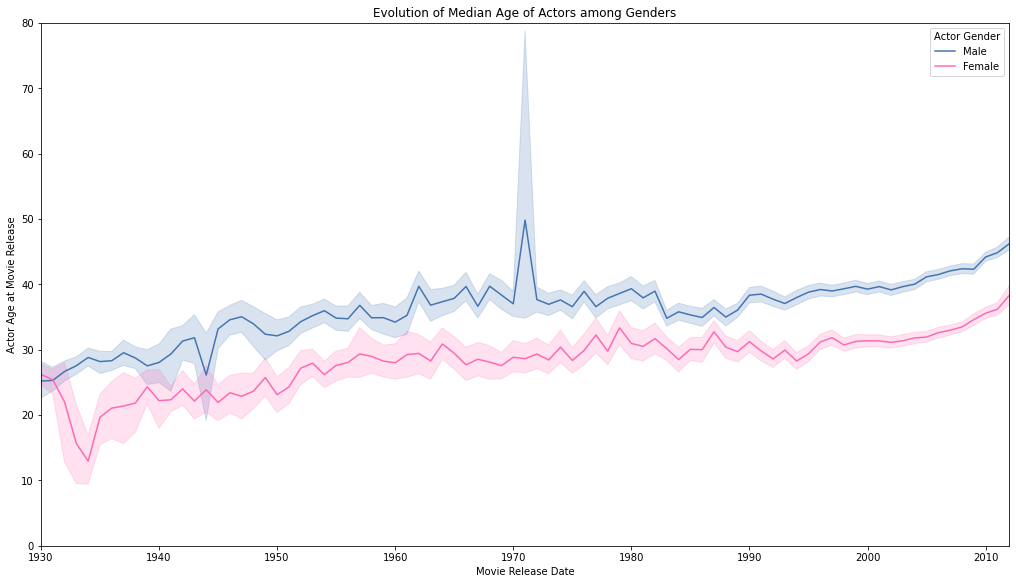

In [71]:
fig, ax = plt.subplots(figsize=(14,8), constrained_layout=True)
colors = ["#4374B3", "#FF69B4"] #4374B3= blue, #FF69B4= hotpink
#Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_age_at_movie_release',hue='Actor_gender',
             ax=ax, legend= False)
plt.xlim([1930, 2012])
plt.xlabel('Movie Release Date')
plt.ylabel('Actor Age at Movie Release')
plt.ylim(0,80)
plt.legend(title='Actor Gender', loc='upper right', labels=['Male', 'Female'])
plt.title('Evolution of Median Age of Actors among Genders')

if SAVE_FIG:
    plt.savefig('Images/actors_age_over_time.png')

### Movie Genres

Datasets:
- df_gender contains the number of male/female actors per film, and the percentage of females
- df_gender_eng is the same, filtered on American movies, in English or Amercian
- movies_treat/movies_control are the 2 dataframes containing the data of df_all before the matching, for each group (and American films, in English/American)
- df_match contains all the films that have been matched. It contains a column 'group' which equald 'treat' if the film is in the treated group, 'control' otherwise (simple to make graphs: use hue='group')
- df_before_match contains all films in USA in English or American. It has the same columns as df_match.

In [18]:
# Group by film (wiki id)
grouped = characters[['Wikipedia_movie_ID','Actor_gender']].groupby(characters.Wikipedia_movie_ID)
# count nb of actor for each gender
df_gender = grouped.agg('sum')
df_gender['nb_m'] = grouped['Actor_gender'].agg('count').values - grouped['Actor_gender'].agg('sum').values
df_gender.rename(columns = {'Actor_gender':'nb_f'}, inplace = True)
# compute the percentage of female actress for each film
df_gender['ratio'] = df_gender['nb_f']/(df_gender['nb_f']+df_gender['nb_m'])*100
global_mean = df_gender.ratio.mean()
df_gender.head()

,nb_f,nb_m,ratio
Wikipedia_movie_ID,,,
3217,2,0,100.000000
3746,0,3,0.000000
3837,1,5,16.666667
4227,0,1,0.000000
4231,3,5,37.500000


In [19]:
# dictionnary computing the number of female and male actors for each gender
gender_per_genre ={}
# iteration over the films
for idx,row in movies.iterrows():
    # get list of genres of the film
    genre_list = row.Movie_genres
    # if the film is in df_gender, get the nb of female and male actors
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    # for each genre of the film
    for g in genre_list:
        # update the dictionnary
        if g not in gender_per_genre:
            gender_per_genre[g] = [nb_m,nb_f]
        else:
            gender_per_genre[g][0] += nb_m
            gender_per_genre[g][1] += nb_f

# put this into a dataframe
df_gender_per_genre = pd.DataFrame.from_dict(gender_per_genre,orient='index')
df_gender_per_genre['ratio'] = df_gender_per_genre[1]/(df_gender_per_genre[0]+df_gender_per_genre[1])*100
df_gender_per_genre.sort_values(by='ratio',inplace=True,ascending=False)
df_gender_per_genre_lim = df_gender_per_genre[df_gender_per_genre[0]+df_gender_per_genre[1] >= 800]
df_gender_per_genre.head(4)

,0,1,ratio
Hardcore pornography,0,1,100.0
Breakdance,0,1,100.0
Filipino Movies,0,1,100.0
Women in prison films,0,2,100.0


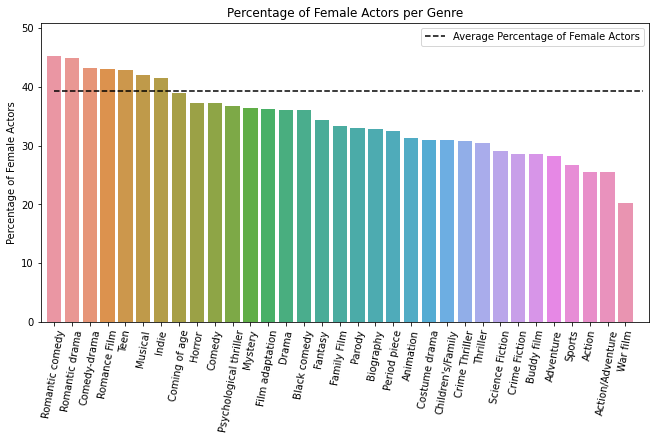

In [64]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)
sns.barplot(data=df_gender_per_genre_lim, x=df_gender_per_genre_lim.index, y='ratio')
plt.hlines(global_mean,0,len(df_gender_per_genre_lim.index),linestyle='--',color='black',label='Average Percentage of Female Actors')
plt.xticks(rotation=80)
plt.margins(0.01, 0.125)
plt.ylabel('Percentage of Female Actors')
plt.title('Percentage of Female Actors per Genre')
plt.legend()

if SAVE_FIG:
    plt.savefig('Images/female_actors_movie_genres.png')

In [55]:
fig = px.bar(df_gender_per_genre_lim, x=df_gender_per_genre_lim.index, y='ratio', color_discrete_sequence=["#FF69B4"],
             template= 'simple_white', labels={'ratio': 'Percentage of Female Actors', 'index' : 'Movie Genre'},
             title= 'Percentage of Female Actors per Genre', height=450, width=650)
fig.update_xaxes(tickangle=300)
fig.add_hline(line_color = 'black', line_dash= 'dash', y=39.33)
fig.show()

if SAVE_FIG:
    fig.write_html("Images/female_actors_movie_genres.html")

### Visualizations for the matching study (success)

In [20]:
# Seleciton of films in USA in english or american
USA = 'United States of America'
eng = 'English Language'
american = 'American English'
mask = movies.apply(lambda x:USA in x.Movie_countries and (eng in x.Movie_languages or american in x.Movie_languages),axis=1)
id_eng = movies.loc[mask,'Wikipedia_movie_ID'].values
df_gender_eng = df_gender[df_gender.index.isin(id_eng)]

eps = 10
nb_actor = 3
sigma_y = df_all.Movie_release_date.std()
control_df = df_gender_eng[df_gender_eng.ratio < global_mean-eps]
treat_df = df_gender_eng[df_gender_eng.ratio > global_mean+eps]
movies_control = df_all[df_all.Wikipedia_movie_ID.isin(control_df.index)]
movies_treat = df_all[df_all.Wikipedia_movie_ID.isin(treat_df.index)]
movies_control.loc[:,'group'] = 'control'
movies_treat.loc[:,'group'] = 'treat'
df_before_match = pd.concat([movies_control,movies_treat],axis=0)

# Standard deviation in log revenue, and log(geometric means)
std_control = movies_control.log_revenue.std()
std_treat = movies_treat.log_revenue.std()
mean_control = movies_control.log_revenue.mean()
mean_treat = movies_treat.log_revenue.mean()

<ipython-input-20-5e6ac28a859a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_control.loc[:,'group'] = 'control'
<ipython-input-20-5e6ac28a859a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_treat.loc[:,'group'] = 'treat'


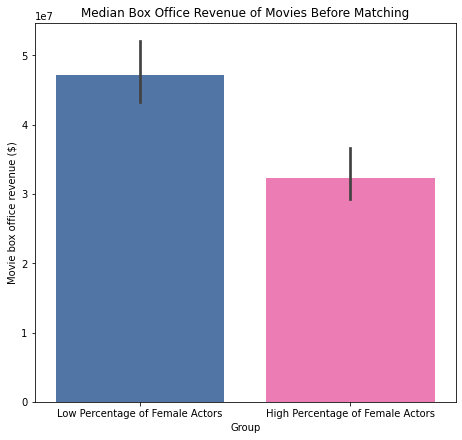

In [32]:
fig,ax = plt.subplots(figsize=(10,6), constrained_layout=True)
sns.barplot(data = df_before_match, y='Movie_box_office_revenue',x='group', order=["control", "treat"], ax=ax,
            palette=colors, estimator=np.median).set(xlabel='Group', ylabel='Movie box office revenue (\$)')
ax.set_xticklabels(['Low Percentage of Female Actors', 'High Percentage of Female Actors'])
ax.set_box_aspect(1.8/len(ax.patches))
plt.title('Median Box Office Revenue of Movies Before Matching')

if SAVE_FIG:
    plt.savefig('Images/revenue_before_matching.png')

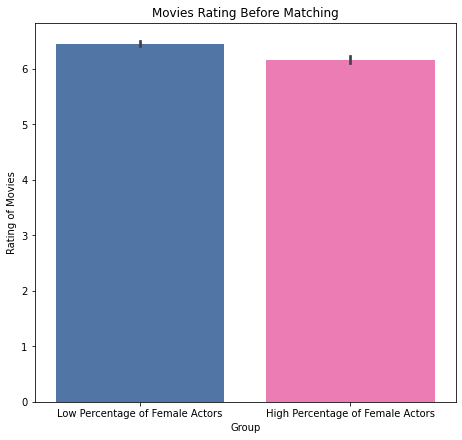

In [33]:
fig,ax = plt.subplots(figsize=(10,6), constrained_layout=True)
sns.barplot(data = df_before_match, y='averageRating',x='group', order=["control", "treat"], ax=ax,
            palette=colors, estimator=np.mean).set(xlabel='Group', ylabel='Rating of Movies')
ax.set_xticklabels(['Low Percentage of Female Actors', 'High Percentage of Female Actors'])
ax.set_box_aspect(1.8/len(ax.patches))
plt.title('Movies Rating Before Matching')

if SAVE_FIG:
    plt.savefig('Images/ratings_before_matching.png')

In [27]:
# Find the minimal matching by distance <-> maximal matching by similarity
matching = nx.algorithms.bipartite.matching.minimum_weight_full_matching(G) #(Wiki_id_control, Wiki_id_treat)

In [28]:
# Creation of the new dataframe
df_match = df_all[df_all.Wikipedia_movie_ID.isin(list(matching.keys()) + list(matching.values()))]
# annotate control/treated group
for key,val in matching.items():
    df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'
    df_match.loc[df_match.Wikipedia_movie_ID == val,'group'] = 'treat'
df_match.head()

<ipython-input-28-3ac3c1b1f08d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'


,genre,score,votes,director,writer,star,country,budget,company,Wikipedia_movie_ID,...,tconst,titleType,isAdult,genres,tconstIdentifier,averageRating,numVotes,log_revenue,log_budget,group
76,Comedy,6.9,68000.0,Ivan Reitman,Len Blum,Bill Murray,United States,10000000.0,Columbia Pictures,560511,...,tt0083131,movie,0,"Comedy,War",tt0083131,6.8,74616,7.930934,7.000000,treat
77,Adventure,7.4,59000.0,John Boorman,Thomas Malory,Nigel Terry,United Kingdom,11000000.0,Cinema '84,250699,...,tt0082348,movie,0,"Adventure,Drama,Fantasy",tt0082348,7.3,62537,7.543664,7.041393,treat
79,Action,6.9,42000.0,Desmond Davis,Beverley Cross,Laurence Olivier,United Kingdom,15000000.0,Charles H. Schneer Productions,948548,...,tt0082186,movie,0,"Action,Adventure,Family",tt0082186,6.9,44884,7.612784,7.176091,control
84,Crime,6.6,22000.0,Bob Rafelson,David Mamet,Jack Nicholson,West Germany,12000000.0,CIP Filmproduktion GmbH,5429460,...,tt0082934,movie,0,"Crime,Drama,Romance",tt0082934,6.6,24083,7.086360,7.079181,control
89,Drama,6.8,17000.0,Harold Becker,Darryl Ponicsan,George C. Scott,United States,14000000.0,Major Studio Partners,30863819,...,tt0083169,movie,0,Drama,tt0083169,6.7,18834,7.544108,7.146128,treat


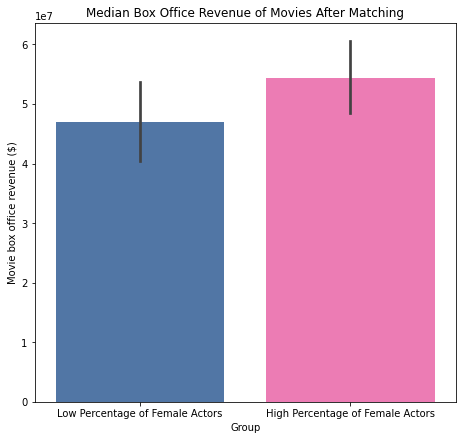

In [34]:
fig,ax = plt.subplots(figsize=(10,6), constrained_layout=True)
sns.barplot(data = df_match, y='Movie_box_office_revenue',x='group', order=["control", "treat"], ax=ax,
            palette=colors, estimator=np.median).set(xlabel='Group', ylabel='Movie box office revenue (\$)')
ax.set_xticklabels(['Low Percentage of Female Actors', 'High Percentage of Female Actors'])
ax.set_box_aspect(1.8/len(ax.patches))
plt.title('Median Box Office Revenue of Movies After Matching')

if SAVE_FIG:
    plt.savefig('Images/revenue_after_matching.png')

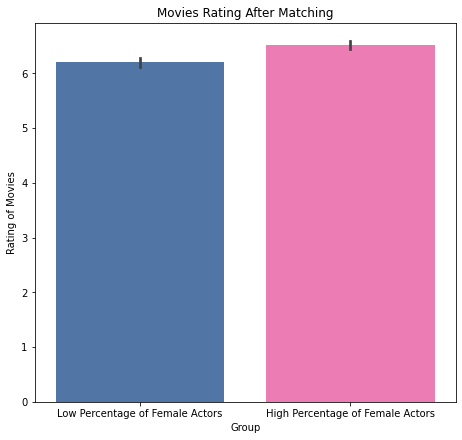

In [35]:
fig,ax = plt.subplots(figsize=(10,6), constrained_layout=True)
sns.barplot(data = df_match, y='averageRating',x='group', order=["control", "treat"], ax=ax,
            palette=colors, estimator=np.mean).set(xlabel='Group', ylabel='Rating of Movies')
ax.set_xticklabels(['Low Percentage of Female Actors', 'High Percentage of Female Actors'])
ax.set_box_aspect(1.8/len(ax.patches))
plt.title('Movies Rating After Matching')

if SAVE_FIG:
    plt.savefig('Images/ratings_after_matching.png')